# FuseTS - Calculating phenometrics using S2

Welcome to this Jupyter notebook, where we explore the Phenology service within the FuseTS toolbox. 

Our objective is to use openEO to generate an NDVI (Normalized Difference Vegetation Index) datacube. This datacube will serve as input for our Phenology process, enabling us to calculate phenometrics.
To enhance the accuracy of our results, we'll take advantage of the FuseTS Whittaker service, employing it to smooth the raw NDVI values. The final calculation is done based on the [phenolopy](https://github.com/lewistrotter/PhenoloPy) python package.

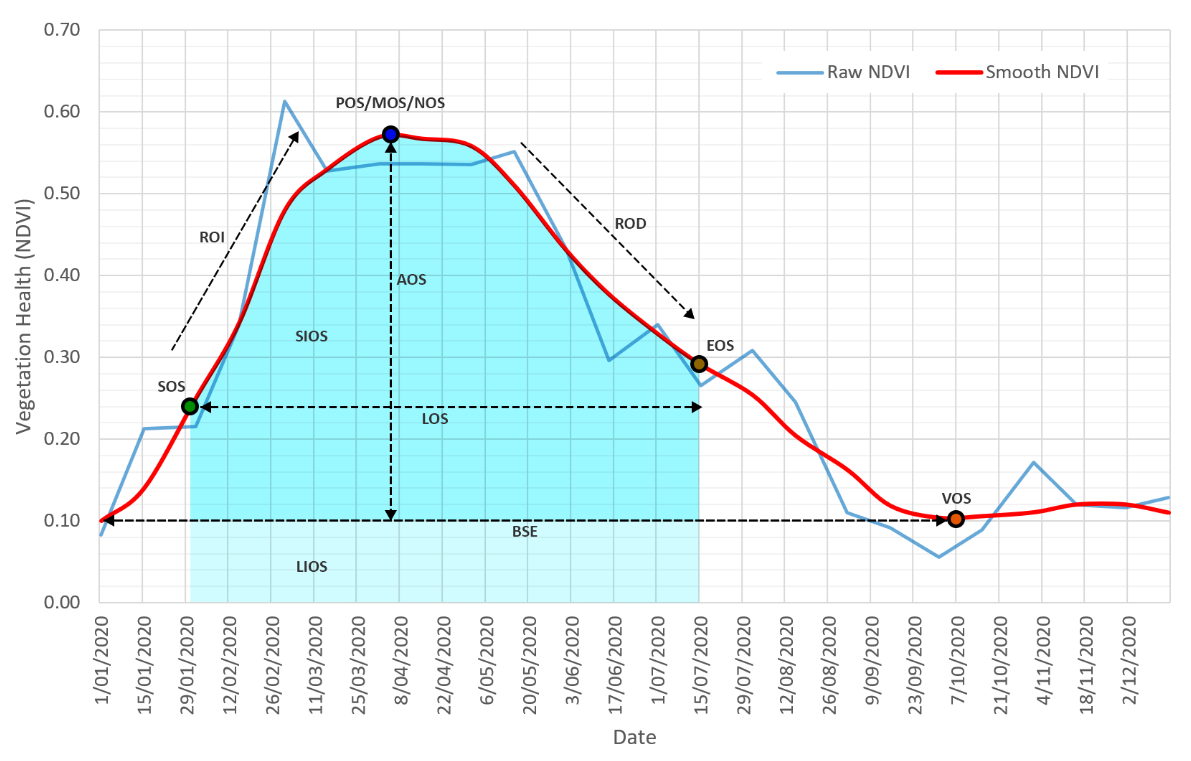

**Prerequisites**
* In this notebook we are using openEO to fetch the time series data for the meadow. You can register for a free trial account on the [openEO Platform](https://openeo.cloud/#plans) website.

### Use `datacube_from_process` to get initial DataCube
Get output datacube from process by passing in the process parameters:
**Mandatory**
- `data`: The initial datacube upon which to execute the Phenology service

In [1]:
import openeo
import json
import pandas as pd
import xarray
import matplotlib.pyplot as plt
from openeo.rest.conversions import timeseries_json_to_pandas
from openeo.metadata import CollectionMetadata
from shapely.geometry import box
import matplotlib.pyplot as plt
import datetime

In [2]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()
service = 'phenology'
namespace = 'u:bramjanssen'

Authenticated using refresh token.


Let start by defining the input parameters that are used to construct our initial datacube. This also includes the `smoothing_lambda` which is used to first smooth the datacube using the Whittaker service, included in the FuseTS package.

In [3]:
year = 2022
spat_ext =  {
        "coordinates": [
          [
            [
              5.179169745059369,
              51.24984286550534
            ],
            [
              5.170016107999743,
              51.25052999567865
            ],
            [
              5.171081610725707,
              51.24861004739975
            ],
            [
              5.178604705735125,
              51.246720335821465
            ],
            [
              5.179169745059369,
              51.24984286550534
            ]
          ]
        ],
        "type": "Polygon"
      }
temp_ext = [f"{year}-05-01", f"{year}-09-30"]
smoothing_lambda=5000

To begin, we calculate the base NDVI data cube. This is done by using the different processes provided by openEO.

In [4]:
s2 = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["B04","B08","SCL"])
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
s2 = s2.mask_polygon(spat_ext)
base_ndvi = s2.ndvi(red="B04", nir="B08")

Next, we utilize this data cube to implement Whittaker smoothing.

In [6]:
smoothed_ndvi = connection.datacube_from_process('whittaker', namespace=f'https://openeo.vito.be/openeo/1.1/processes/{namespace}/whittaker', data=base_ndvi, smoothing_lambda=smoothing_lambda)

/home/bramjanssen/.local/lib/python3.6/site-packages/openeo/metadata.py:255: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


Finally we apply the resulting data cube as input for the Phenology service and create our final data cube.

In [7]:
phenology = connection.datacube_from_process(service, namespace=f'https://openeo.vito.be/openeo/1.1/processes/{namespace}/{service}', data=smoothed_ndvi)

### Execute job and download result

Using a batch job, we can download the phenology results to a NetCDF file.

In [8]:
phenology_job = phenology.execute_batch(out_format="netcdf", title=f'FuseTS - Phenology', job_options={
    'udf-dependency-archives': [
         'https://artifactory.vgt.vito.be:443/auxdata-public/ai4food/fusets_venv.zip#tmp/venv',
        'https://artifactory.vgt.vito.be:443/auxdata-public/ai4food/fusets.zip#tmp/venv_static'
    ]
})

phenology_output_file = './phenology.nc'

results = phenology_job.get_results()
results.download_file(phenology_output_file)

0:00:00 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': send 'start'
0:00:19 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': queued (progress N/A)
0:00:24 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': queued (progress N/A)
0:00:30 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': queued (progress N/A)
0:00:38 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': queued (progress N/A)
0:00:48 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': queued (progress N/A)
0:01:01 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': queued (progress N/A)
0:01:16 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': queued (progress N/A)
0:01:36 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': queued (progress N/A)
0:02:00 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': running (progress N/A)
0:02:30 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': running (progress N/A)
0:03:26 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': running (progress N/A)
0:04:13 Job 'j-a5b87c3f55ae42a8aad587df77e8e1ae': finished (progress N/A)


PosixPath('phenology.nc')

We also download the results from the smoothed NDVI data cube in order to compare the time series data with the results from the Phenology service.

In [9]:
ndvi_output_file = './s2_phenology_ndvi.nc'
base_ndvi.execute_batch(out_format="netcdf", title='FuseTS - Phenology - NDVI').get_results().download_file(ndvi_output_file)

0:00:00 Job 'j-36c740b6bb524159a85313ad39527e03': send 'start'
0:00:19 Job 'j-36c740b6bb524159a85313ad39527e03': queued (progress N/A)
0:00:24 Job 'j-36c740b6bb524159a85313ad39527e03': queued (progress N/A)
0:00:31 Job 'j-36c740b6bb524159a85313ad39527e03': queued (progress N/A)
0:00:39 Job 'j-36c740b6bb524159a85313ad39527e03': queued (progress N/A)
0:00:49 Job 'j-36c740b6bb524159a85313ad39527e03': queued (progress N/A)
0:01:01 Job 'j-36c740b6bb524159a85313ad39527e03': queued (progress N/A)
0:01:16 Job 'j-36c740b6bb524159a85313ad39527e03': queued (progress N/A)
0:01:36 Job 'j-36c740b6bb524159a85313ad39527e03': queued (progress N/A)
0:02:00 Job 'j-36c740b6bb524159a85313ad39527e03': running (progress N/A)
0:02:44 Job 'j-36c740b6bb524159a85313ad39527e03': running (progress N/A)
0:03:22 Job 'j-36c740b6bb524159a85313ad39527e03': running (progress N/A)
0:04:09 Job 'j-36c740b6bb524159a85313ad39527e03': finished (progress N/A)


PosixPath('s2_phenology_ndvi.nc')

## Explore the results

In [10]:
phenology_result_nc = xarray.load_dataset(phenology_output_file)
ndvi_nc = xarray.load_dataset(ndvi_output_file)

In [11]:
average_ndvi = ndvi_nc.median(dim=['x', 'y']).to_array()

sos = phenology_result_nc.sos_times.median(dim=['x', 'y']).values.take(0)
pos = phenology_result_nc.pos_times.median(dim=['x', 'y']).values.take(0)
eos = phenology_result_nc.eos_times.median(dim=['x', 'y']).values.take(0)

sos_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=sos)
pos_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=pos)
eos_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=eos)

/usr/local/lib64/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


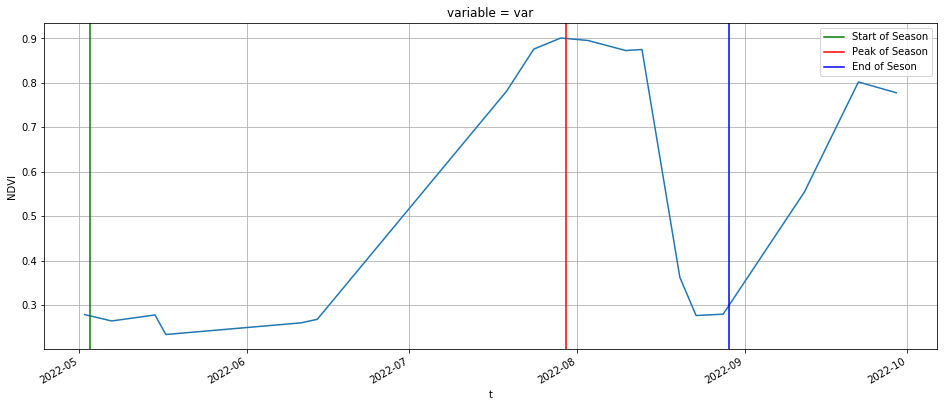

In [12]:
plt.figure(figsize= (16,6))
average_ndvi.plot()
plt.ylabel ('NDVI')
plt.axvline(x = sos_date, color = 'g', label = 'Start of Season')
plt.axvline(x = pos_date, color = 'r', label = 'Peak of Season')
plt.axvline(x = eos_date, color = 'b', label = 'End of Seson')
plt.grid(True)
plt.legend()